In [1]:
###########################
# convert amodal to our formulation
###########################
import sys
sys.path.append("..")

from modal.amodal import Amodal
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2,os
from skimage import morphology
from skimage.measure import regionprops

In [24]:
#use number to label areas, 2**i = visual areas index for amodal i ,2**(32+i) = invisual mask index for amodal i

def reLayerMask(mask_amodal, mask_invis):
    mask_zeros = np.zeros(mask_amodal[0].shape).astype('bool')
    labal = np.zeros(mask_amodal[0].shape).astype('uint64')
    for i in range(len(mask_amodal)):
        if i >= 32:
            continue
        if len(mask_invis[i]):
            invis = mask_invis[i] > 0
            labal[invis] |= 1 << (i + 32)
            mask_vis = (mask_amodal[i]>0)^invis
        else:
            mask_vis = mask_amodal[i]

        labal[mask_vis > 0] |= 1 << i

    labal = remove_small_path(labal, min_size=64)
    return labal


def remove_small_path(labal, min_size=64):
    color = np.unique(labal)
    for i in range(len(color)):
        mask = (labal == color[i])
        mask_new = morphology.remove_small_objects(mask, min_size=min_size)
        if not mask_new.max():
            labal[mask] = 0
    return labal


def get_image_labals(labal):
    labal_ids = np.unique(labal)
    if labal_ids[0] == 0:
        labal_ids = np.delete(labal_ids, 0)
    return labal_ids


# id start from 0
def objectID_to_masks(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)

    mask_vis, mask_invis = [], []
    index_vis = ((labal_ids >> id) & 1 == 1).nonzero()
    index_invis = ((labal_ids >> np.uint64(id + 32)) & 1 == 1).nonzero()

    for items in index_vis:
        for i in range(items.size):
            mask_vis.append(labal == labal_ids[items[i]])
    for items in index_invis:
        for i in range(items.size):
            mask_invis.append(labal == labal_ids[items[i]])

    return (mask_vis, index_vis, mask_invis, index_invis)


# id start from 0, id<0 return all masks
def maskID_to_mask(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)

    mask = []
    if id < 0:
        for items in labal_ids:
            mask.append(labal == items)
        return mask
    else:
        return labal == labal_ids[id]


def number_to_index(labal_id):
    bin_index, objectID = 0, []
    while labal_id:
        if labal_id & np.uint64(1):
            return bin_index
        bin_index += 1
        labal_id = labal_id >> np.uint64(1)



def remove_last_one(number, depth):
    while number and depth:
        number = np.bitwise_and(number,np.uint64(number - 1))
        depth -= 1
    return number


# id start from 0
# return vis object id invis layer 1 - n
def maskID_to_objectIDs(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)
    labal_id = labal_ids[id]

    vis = (labal_id << np.uint64(32)) >> np.uint64(32)  # remove highest 32 bit
    invis = labal_id >> np.uint64(32)  ## remove lowest 32 bit

    object_id_vis = number_to_index(vis)
    object_id_invis = number_to_index(invis)
    object_id_vis.extend(object_id_invis)
    return object_id_vis


def layer_to_mask(labal, depth, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)
    mask, objectID = [], []
    vis = (labal_ids << np.uint64(32)) >> np.uint64(32)
    if 0 == depth:
        for i in range(len(vis)):
            mask.append(maskID_to_mask(labal, i))
            objectID.append(number_to_index(vis[i]))
        return (mask, objectID)

    else:
        # find (depth)th 1 from left to right, is exist have depth layer else not
        depth -= 1
        labal_inds = []
        invis = labal_ids >> np.uint64(32)
        for i in range(len(invis)):#len(invis)
            new_labal = remove_last_one(invis[i], depth)
                
            if new_labal:

                object_id = number_to_index(new_labal)#the first vis object index
                _, _, mask_invis, index_invis =objectID_to_masks(labal, object_id, labal_ids)
                

                for k in range(len(index_invis)):
                    labal_ind = labal_ids[index_invis[0][k]] 

                    new_labal_2 = remove_last_one(labal_ind >> np.uint64(32),depth)
                    if new_labal_2 and object_id == number_to_index(new_labal_2):
                        if labal_ind not in labal_inds:
                            labal_inds.append(labal_ind)
                            mask.append(mask_invis[k])
                            objectID.append(object_id)

        return (mask, objectID)

In [34]:
dataMode = 'D2S' # D2S or coco_amodal
dataType = 'train' # train or val
ann_file = '../datasets/%s/annotations/COCO_amodal_%s2014.json'%(dataMode,dataType)
amodal = Amodal(ann_file)

loading annotations into memory...
Done (t=2.32s)
creating index...
index created!


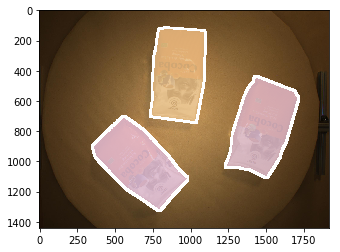

In [35]:
# random select one image
dataDir = '../datasets/%s/%s2014'%(dataMode,dataType)
imgId = amodal.dataset['images'][0]['id']
annIds = amodal.getAmodalAnnIds(imgIds=imgId)
anns = amodal.loadAnns(annIds)
ann = random.choice(anns)
img = amodal.loadImgs(imgId)[0]
I = cv2.imread(os.path.join(dataDir, img['file_name']))
plt.figure()
plt.imshow(I[...,::-1])
amodal.showAmodalAnns(ann) 

In [36]:
images = amodal.dataset['images']
Image_anns = []
for img in images:
    Image_ann = []
    imgId = img['id']
    annIds = amodal.getAmodalAnnIds(imgIds=imgId)
    ann = amodal.loadAnns(annIds)[0]
    
    mask_invis_s = []
    Image_ann = {'id': imgId}
    Image_ann['mask_amodals'] = []
    for depth in range(len(ann['regions'])):
        mask,mask_invis = amodal.getAmodalInstance(ann,img['width'],img['height'], depth)
        Image_ann['mask_amodals'].append(mask)
        
        mask_invis_s.append(mask_invis)

    
    img_labal = reLayerMask(Image_ann['mask_amodals'],mask_invis_s)
    np.savez_compressed(os.path.join(dataDir,img['file_name'][:-4]), layer=img_labal)
    #labal_ids = get_labalIDs(img_labal)
    #Image_anns.append(img_labal)

In [ ]:
plt.imshow(np.load(os.path.join(dataDir,img['file_name'][:-4]+'.npz'))['layer'])